In [1]:
import librosa
import soundfile
import os
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.models import Model
from keras.layers import (
    Conv1D,
    Activation,
    Dropout,
    MaxPooling1D,
    Flatten,
    Dense,
    Input,
)
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Function to recursively get all audio files from a directory
def get_audio_files(base_path):
    audio_files = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


# Base path for RAVDESS dataset
base_path_RAVDESS = "../data/raw/audio_speech_actors_01-24"

# Get all audio files from RAVDESS and TESS datasets
audio_files_ravdess = get_audio_files(base_path_RAVDESS)
# Save audio files paths
if not os.path.exists("../data/processed/audio_files_ravdess.txt"):
    with open("../data/processed/audio_files_ravdess.txt", "w") as f:
        for item in audio_files_ravdess:
            f.write("%s\n" % item)
    print("../data/processed/audio_files_ravdess.txt already exists is created")
else:
    print("../data/processed/audio_files_ravdess.txt already exists")

../data/processed/audio_files_ravdess.txt already exists


In [5]:
# Function to extract mfcc, chroma, mel, and contrast features from audio files
def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack(
            (
                np.mean(mfccs, axis=1),
                np.mean(chroma, axis=1),
                np.mean(mel, axis=1),
                np.mean(contrast, axis=1),
            )
        )
        return features
    except Exception:
        print(f"Error encountered while parsing file: {file_path}")
        return None


# Load audio files from the text file
audio_files_ravdess = []
with open("../data/processed/audio_files_ravdess.txt", "r") as file:
    audio_files_ravdess = [line.strip() for line in file.readlines()]

# Extract features from all audio files
features_ravdess = []
labels_ravdess = []
label_map_tess = {
    "OAF_angry": 4,
    "OAF_disgust": 6,
    "OAF_Fear": 5,
    "OAF_happy": 2,
    "OAF_Pleasant_surprise": 7,
    "OAF_Sad": 3,
    "OAF_neutral": 0,
    "YAF_angry": 4,
    "YAF_disgust": 6,
    "YAF_fear": 5,
    "YAF_happy": 2,
    "YAF_pleasant_surprised": 7,
    "YAF_sad": 3,
    "YAF_neutral": 0,
}
label_map_ravdess = {
    "01": 0,
    "02": 1,
    "03": 2,
    "04": 3,
    "05": 4,
    "06": 5,
    "07": 6,
    "08": 7,
}
if not os.path.exists("../data/processed/features.npy"):
    for idx, file in enumerate(audio_files_ravdess, start=1):
        feature = extract_features(file)
        if feature is not None:
            features_ravdess.append(feature)
            if "audio_speech_actors_01-24" in file:
                # Extract label from RAVDESS file name
                label = file.split(os.sep)[-1].split("-")[2]
                labels_ravdess.append(label_map_ravdess[label])
            else:
                # Extract label from TESS file path
                emotion = file.split(os.sep)[-2]
                if emotion in label_map_tess:
                    labels_ravdess.append(label_map_tess[emotion])
                else:
                    print(f"Skipping {file} with unrecognized emotion: {emotion}")
                    features_ravdess.pop()  # Remove the feature if label is not recognized
            print(f"Processing file {idx} of {len(audio_files_ravdess)}")

    print("Feature extraction complete.")
    features_ravdess = np.array(features_ravdess)
    np.save("../data/processed/features_ravdess.npy", features_ravdess)
    labels_ravdess = np.array(labels_ravdess)
    np.save("../data/processed/labels_ravdess.npy", labels_ravdess)
else:
    # Load features and labels
    features_ravdess = np.load("../data/processed/features_ravdess.npy")
    labels_ravdess = np.load("../data/processed/labels_ravdess.npy")
    print("loaded")

loaded


In [6]:
# Convert the features and labels into numpy arrays
X = np.array(features_ravdess)
y = np.array(labels_ravdess)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape data to fit the model: (num_samples, timesteps, num_features)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [7]:
# Initialize a sequential model
model = Sequential()

# First convolutional layer with 64 filters, kernel size 5, 'same' padding, and ReLU activation
# Input shape is (num_features, 1)
model.add(
    Conv1D(64, 5, padding="same", input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Second convolutional layer with 128 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(128, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=4))

# Third convolutional layer with 256 filters, kernel size 5, 'same' padding, and ReLU activation
model.add(Conv1D(256, 5, padding="same"))
model.add(Activation("relu"))
model.add(Dropout(0.1))

# Flatten the output for the dense layer
model.add(Flatten())

# Dense layer with 8 units and softmax activation for multi-class classification
model.add(Dense(8))
model.add(Activation("softmax"))

# Define the RMSprop optimizer with a lower learning rate
opt = RMSprop(learning_rate=0.001)

# Compile the model with categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

# Print a summary of the model architecture
model.summary()

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        22,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,104 (891.03 KB)

 Trainable params: 228,104 (891.03 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model with sparse categorical crossentropy loss and the defined optimizer
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [9]:
# Ensure X_train and X_test are reshaped correctly
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1531 - loss: 8.9362 - val_accuracy: 0.2396 - val_loss: 1.9374
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2243 - loss: 1.9974 - val_accuracy: 0.2708 - val_loss: 1.8685
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2279 - loss: 1.8982 - val_accuracy: 0.2812 - val_loss: 1.8798
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3011 - loss: 1.8311 - val_accuracy: 0.2604 - val_loss: 1.9754
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3322 - loss: 1.7835 - val_accuracy: 0.3229 - val_loss: 1.7546
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3872 - loss: 1.6398 - val_accuracy: 0.2535 - val_loss: 1.6819
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3748 - loss: 1.6036 - val_accuracy: 0.3090 - val_loss: 1.7210
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4025 - loss: 1.5391 - val_accuracy: 0.3750 - v

Test accuracy: 0.5520833134651184
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.56      0.26      0.36        19
           1       0.60      0.84      0.70        38
           2       0.39      0.47      0.43        38
           3       0.47      0.58      0.52        38
           4       0.82      0.59      0.69        39
           5       0.52      0.33      0.41        39
           6       0.53      0.47      0.50        38
           7       0.61      0.72      0.66        39

    accuracy                           0.55       288
   macro avg       0.56      0.53      0.53       288
weighted avg       0.56      0.55      0.54       288



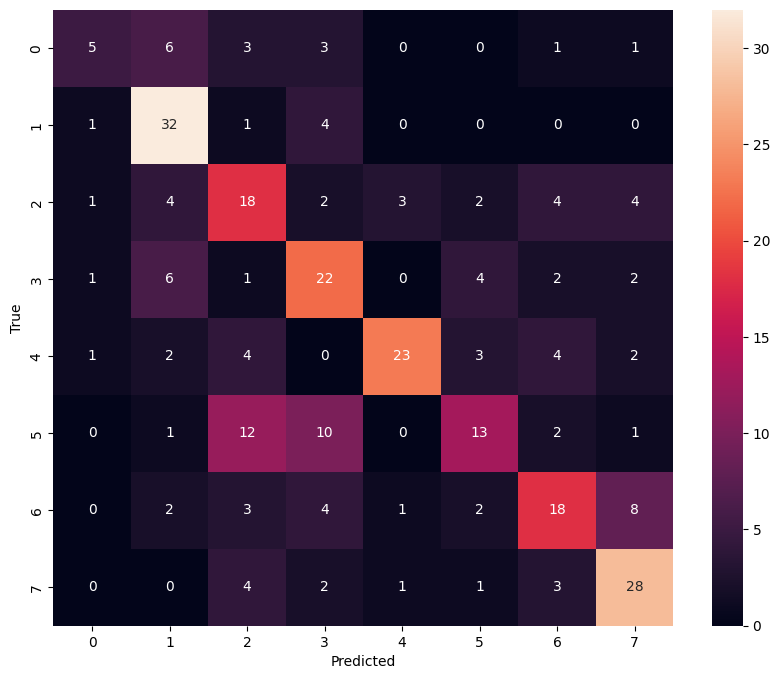

In [10]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {score[1]}")

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

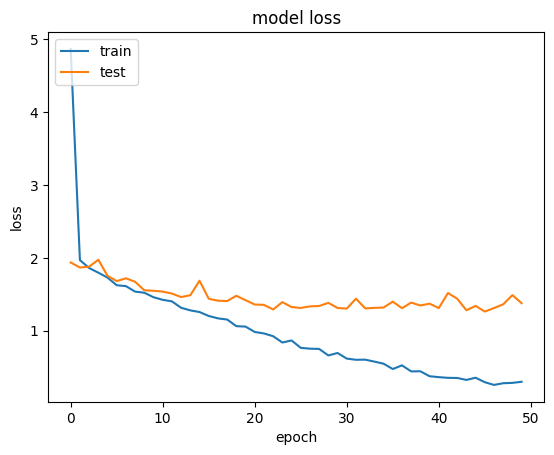

In [11]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

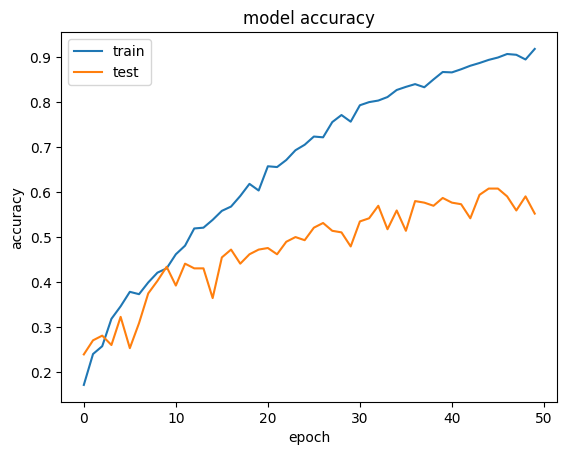

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
# Perform k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store accuracy for each fold
cv_accuracies = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Reshape data to fit the model: (num_samples, timesteps, num_features)
    X_train_cv = np.expand_dims(X_train_cv, axis=-1)
    X_val_cv = np.expand_dims(X_val_cv, axis=-1)

    # Initialize a new model for each fold
    model_cv = Sequential()

    model_cv.add(
        Conv1D(
            64,
            5,
            padding="same",
            input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]),
        )
    )
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(128, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))
    model_cv.add(MaxPooling1D(pool_size=4))

    model_cv.add(Conv1D(256, 5, padding="same"))
    model_cv.add(Activation("relu"))
    model_cv.add(Dropout(0.1))

    model_cv.add(Flatten())

    model_cv.add(Dense(8))
    model_cv.add(Activation("softmax"))

    # Define a new RMSprop optimizer with a lower learning rate for each fold
    opt_cv = RMSprop(learning_rate=0.001)

    model_cv.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt_cv, metrics=["accuracy"]
    )

    # Train the model
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=1)

    # Evaluate the model on validation data
    y_val_pred = model_cv.predict(X_val_cv)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    accuracy = accuracy_score(y_val_cv, y_val_pred_classes)
    cv_accuracies.append(accuracy)

# Print cross-validation accuracies and mean accuracy
print(f"Cross-validation accuracies: {cv_accuracies}")
print(f"Mean cross-validation accuracy: {np.mean(cv_accuracies)}")

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1190 - loss: 10.7060
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2182 - loss: 2.0312
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2479 - loss: 1.9000
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3158 - loss: 1.8833
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3474 - loss: 1.7241
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3483 - loss: 1.7066
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3836 - loss: 1.6287
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3840 - loss: 1.5540
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4070 - loss: 1.5546
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4347 - loss: 1.5139
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4269 - loss: 1.5246
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1776 - loss: 8.0898
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2347 - loss: 1.9712
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2723 - loss: 1.8602
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3281 - loss: 1.7456
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3364 - loss: 1.6895
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3937 - loss: 1.6319
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3872 - loss: 1.5627
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3869 - loss: 1.5431
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4150 - loss: 1.4939
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4693 - loss: 1.4471
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4499 - loss: 1.4084
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1646 - loss: 9.4843
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2375 - loss: 2.0293
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2583 - loss: 1.8774
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2778 - loss: 1.8198
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3711 - loss: 1.7102
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3692 - loss: 1.6517
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4132 - loss: 1.5787
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4008 - loss: 1.5675
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4039 - loss: 1.5457
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3878 - loss: 1.5146
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4811 - loss: 1.4277
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy:

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1470 - loss: 8.9377
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2423 - loss: 1.9914
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2474 - loss: 1.8731
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2914 - loss: 1.8141
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3506 - loss: 1.6930
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3589 - loss: 1.6628
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3886 - loss: 1.6019
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4178 - loss: 1.5273
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4206 - loss: 1.5209
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4587 - loss: 1.4606
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4431 - loss: 1.4437
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4679 

c:\Users\Med Anis Oueslati\Desktop\internship\EmotionRecognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1582 - loss: 11.4594
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1873 - loss: 2.0314
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2605 - loss: 1.8839
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2904 - loss: 1.7669
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3621 - loss: 1.7316
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3677 - loss: 1.6788
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4032 - loss: 1.5877
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3537 - loss: 1.6087
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4327 - loss: 1.5305
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4304 - loss: 1.5080
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4372 - loss: 1.4679
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy